In [1]:
import string
import os
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from naturalcogsci.helpers import get_project_root

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALLER_SIZE = 6



with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

In [2]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df

In [3]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

In [4]:
merged_df = pd.merge(
    reward_model_df[["features", "color", "nll", "return","feature_key"]],
    category_model_df[["features", "color", "nll", "return","feature_key"]],
    on=["features", "color", "feature_key"],
    suffixes=("_reward", "_category"),
)

merged_df["nll"] = (merged_df["nll_reward"] + merged_df["nll_category"])/2
merged_df["return"] = (merged_df["return_reward"] + merged_df["return_category"])/2
merged_df.drop(["return_reward", "return_category"], axis=1, inplace=True)
merged_df.drop(["nll_reward", "nll_category"], axis=1, inplace=True)
merged_df["model_size"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["size"]
)
merged_df["zero_shot"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["zero-shot"]
)
merged_df["probing"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["probing"]
)

merged_df["training_data"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["data-size"]
)

ax0_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')

ax0_df.model_size = ax0_df.model_size * 1e6

ax1_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax1_df["training_data"] = pd.to_numeric(ax1_df["training_data"], errors='coerce')


r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "r2", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

r2_df = pd.concat(dfs, ignore_index=True)
r2_df = r2_df[r2_df.r2 <= 0.99].reset_index(drop=True)
r2_df = r2_df[r2_df.features.isin(main_feature_names)]

r2_df["color"] = r2_df["features"].apply(lambda x: plot_params[x]["colour"])
r2_df["features"] = r2_df["features"].apply(lambda x: plot_params[x]["name"])

r2_df = pd.merge(r2_df, merged_df, on=["features", "color"], how="outer")

r2_df = r2_df[~r2_df.color.str.startswith("text")].reset_index(drop=True)
r2_df = r2_df[~r2_df.color.str.startswith("task")].reset_index(drop=True)

r2_df = r2_df[~r2_df.isna().any(axis=1)].reset_index(drop=True)

task_cka_df = pd.read_csv(join(PROJECT_ROOT, "data", "cka", "target_task.csv"))
task_cka_df = task_cka_df[task_cka_df.feature.isin(main_feature_names)]
task_cka_df = task_cka_df[task_cka_df.feature != "cornet-rt"].reset_index(drop=True)
task_cka_df = task_cka_df[task_cka_df.feature != "task"].reset_index(drop=True)
task_cka_df["color"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["colour"])

task_cka_df["features"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["name"])
task_cka_df = pd.merge(
    task_cka_df,
    merged_df[["features", "color", "nll"]],
    on=["features", "color"],
    how="outer",
)

task_cka_df["cka"] = np.where(task_cka_df["color"] == "task", 1, task_cka_df["cka"])


task_cka_df = task_cka_df[~task_cka_df.isna().any(axis=1)].reset_index(drop=True)

r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "ID", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

id_df = pd.concat(dfs, ignore_index=True)

id_df = id_df[id_df.features.isin(main_feature_names)]

id_df["color"] = id_df["features"].apply(lambda x: plot_params[x]["colour"])
id_df["features"] = id_df["features"].apply(lambda x: plot_params[x]["name"])

id_df = pd.merge(id_df, merged_df, on=["features", "color"], how="outer")
id_df=id_df[id_df.color.isin(["self-supervised","supervised","multimodal"])]

/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/4162039254.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/4162039254.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ax0_df.model_size = ax0_df.model_size * 1e6
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/4162039254.py:40: SettingWithCopyWarning: 
A value is trying to be se

In [5]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)

chance_level = - REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby(["features","participant"]).agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df


dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)

model_df["right_value"] = np.where(model_df.right_value == 1, 0.99999, model_df.right_value)
model_df["right_value"] = np.where(model_df.right_value == 0, 0.000001, model_df.right_value)
#model_df["nll"] = - np.log(model_df.right_value)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
#model_df["return"] = np.where(np.round(model_df.right_value) == model_df.true_category_binary, 1, 0)
chance_level = -CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby(["features","participant"]).agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
category_model_df = model_df

In [6]:
aligned_models = [
    "Harmonization_ResNet50",
    "Harmonization_ViT_B16",
    "Harmonization_tiny_ConvNeXT",
    "Harmonization_VGG16",
    "Harmonization_EfficientNetB0",
    "Harmonization_tiny_MaxViT",
    "Harmonization_LeViT_small",
    "DreamSim_open_clip_vitb32",
    "DreamSim_clip_vitb32",
    "gLocal_clip_RN50",
    "gLocal_clip_ViT-L_14",
    "gLocal_dinov2-vit-base-p14",
    "gLocal_dinov2-vit-large-p14",
    "gLocal_OpenCLIP_ViT-B-32_laion400m_e32",
    "gLocal_resnet18",
    "gLocal_resnet50"
    ]

base_models = [
    "resnet50",
    "vit_b_16",
    "convnext_tiny",
    "vgg16",
    "efficientnet",
    "maxvit",
    "levit",
    "OpenCLIP_ViT-B-32_laion400m_e32",
    "clip_ViT-B_32",
    "clip_RN50",
    "clip_ViT-L_14",
    "dinov2-vit-base-p14",
    "dinov2-vit-large-p14",
    "OpenCLIP_ViT-B-32_laion400m_e32",
    "resnet18",
    "resnet50"
]

alignment_df = {
    "Alignment": [],
    "Model" : [],
    "nll" : [],
    "return": [],
    "r2" : [],
    "cka" : [],
    "id": [],
    "colour" : [],
}

for aligned, base in zip(aligned_models, base_models):
    
    alignment_type = aligned.split("_")[0]
    alignment_df["Alignment"].append(alignment_type)
    
    alignment_df["Model"].append(base)

    delta_nll = merged_df[merged_df.feature_key == aligned]["nll"].values - merged_df[merged_df.feature_key == base]["nll"].values
    alignment_df["nll"].append(delta_nll[0])
    delta_return =  merged_df[merged_df.feature_key == aligned]["return"].values - merged_df[merged_df.feature_key == base]["return"].values
    alignment_df["return"].append(delta_return[0])

    delta_r2 = r2_df[r2_df.feature_key == aligned]["r2"].values - r2_df[r2_df.feature_key == base]["r2"].values
    alignment_df["r2"].append(delta_r2[0])

    delta_cka = task_cka_df[task_cka_df.feature == aligned]["cka"].values - task_cka_df[task_cka_df.feature == base]["cka"].values
    alignment_df["cka"].append(delta_cka[0])

    delta_id = id_df[id_df.Feature == aligned]["local ID"].values - id_df[id_df.Feature == base]["local ID"].values
    alignment_df["id"].append(delta_id[0])

    if ("CLIP" in base) or ("clip" in base):
        alignment_df["colour"].append("Multimodal")
    elif "dino" in base:
        alignment_df["colour"].append("Self-Supervised")
    else:
        alignment_df["colour"].append("Supervised")





alignment_df = pd.DataFrame(alignment_df)


/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/3490363996.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=alignment_df,y="Alignment",x="nll",ax=axs[0],color=CMAP[-2],ci=None)
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/3490363996.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=alignment_df,y="Alignment",x="return",ax=axs[1],color=CMAP[-2],ci=None)
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72092/3490363996.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=alignment_df,y="Alignment",x="r2",ax=axs[2],color=CMAP[-2],ci=None)
/Users/candemircan/Projects/cpi/things_hiwi/naturalcogsci/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size o

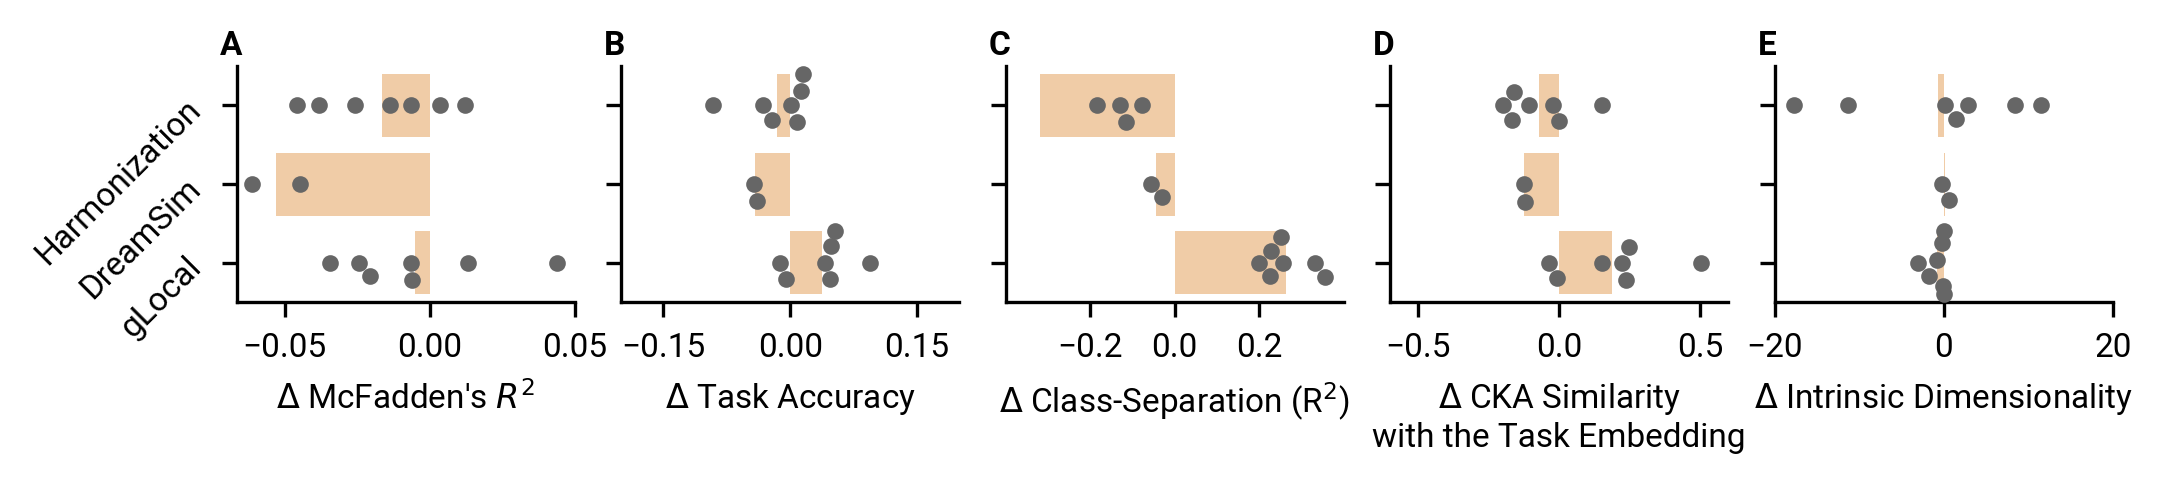

In [7]:
fig, axs = plt.subplots(1,5, figsize=(FIGWIDTH, FIGWIDTH/5),sharey=True)

sns.barplot(data=alignment_df,y="Alignment",x="nll",ax=axs[0],color=CMAP[-2],ci=None)
sns.swarmplot(data=alignment_df,y="Alignment",x="nll",ax=axs[0],color=CMAP[-1],hue_order=["Supervised", "Self-Supervised", "Multimodal"],size=4)
axs[0].set_xlabel(r"$\Delta$ McFadden's $R^2$")
axs[0].set_ylabel("")
axs[0].set_xticks([-.05,0,.05])


sns.barplot(data=alignment_df,y="Alignment",x="return",ax=axs[1],color=CMAP[-2],ci=None)
sns.swarmplot(data=alignment_df,y="Alignment",x="return",ax=axs[1],color=CMAP[-1],hue_order=["Supervised", "Self-Supervised", "Multimodal"],size=4)
axs[1].set_xlabel(r"$\Delta$ Task Accuracy")
axs[1].set_ylabel("")
axs[1].set_xlim([-.2,.2])
axs[1].set_xticks([-.15,0,.15])


sns.barplot(data=alignment_df,y="Alignment",x="r2",ax=axs[2],color=CMAP[-2],ci=None)
sns.swarmplot(data=alignment_df,y="Alignment",x="r2",ax=axs[2],color=CMAP[-1],hue_order=["Supervised", "Self-Supervised", "Multimodal"],size=4)
axs[2].set_xlabel(r"$\Delta$ Class-Separation (R$^2$)")
axs[2].set_ylabel("")
axs[2].set_xlim([-.4,.4])
axs[2].set_xticks([-.2,0,.2])

sns.barplot(data=alignment_df,y="Alignment",x="cka",ax=axs[3],color=CMAP[-2],ci=None)
sns.swarmplot(data=alignment_df,y="Alignment",x="cka",ax=axs[3],color=CMAP[-1],hue_order=["Supervised", "Self-Supervised", "Multimodal"],size=4)
axs[3].set_xlabel("$\Delta$ CKA Similarity\nwith the Task Embedding")
axs[3].set_ylabel("")
axs[3].set_xlim([-.6,.6])

sns.barplot(data=alignment_df,y="Alignment",x="id",ax=axs[4],color=CMAP[-2],ci=None)
sns.swarmplot(data=alignment_df,y="Alignment",x="id",ax=axs[4],color=CMAP[-1],hue_order=["Supervised", "Self-Supervised", "Multimodal"],size=4)
axs[4].set_xlabel("$\Delta$ Intrinsic Dimensionality")
axs[4].set_ylabel("")
axs[4].set_xlim([-20,20])


axs[0].text(-.05, 1.05, string.ascii_uppercase[0], transform=axs[0].transAxes, weight="bold")
axs[1].text(-.05, 1.05, string.ascii_uppercase[1], transform=axs[1].transAxes, weight="bold")
axs[2].text(-.05, 1.05, string.ascii_uppercase[2], transform=axs[2].transAxes, weight="bold")
axs[3].text(-.05, 1.05, string.ascii_uppercase[3], transform=axs[3].transAxes, weight="bold")
axs[4].text(-.05, 1.05, string.ascii_uppercase[4], transform=axs[4].transAxes, weight="bold")


yticklabels = alignment_df['Alignment'].drop_duplicates().tolist()

# Set the y-tick labels for the first subplot
axs[0].set_yticklabels(yticklabels,rotation=45)


plt.tight_layout(pad=-.03)


fig.savefig(join(PROJECT_ROOT, "figures","neurips_alignment.pdf"), bbox_inches='tight')